In [1]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random

In [2]:
# from tensorboard import notebook

# # 初始化 SummaryWriter，日志将保存在'runs'目录下
# writer = SummaryWriter(f"./logs/{datetime.datetime.now()}")

# # 启动 TensorBoard 并指定日志目录
# notebook.start("--logdir runs")

# # 可选：创建一个链接直接跳转到 TensorBoard 界面
# # notebook.display(height=400)

In [3]:
# %matplotlib qt5

In [4]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, hidden_size = 64):
        super(Actor, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = torch.tanh(self.fc_mean(F.relu(x))) * 1.0
        std = F.softplus(self.fc_std(F.relu(x))) #+ 0e-3
        # std = torch.ones_like(mu) * 1.0  # 固定标准差，增强探索

        return mu, std

        
class Critic(nn.Module):
    def __init__(self, n_state, hidden_size=64):
        super(Critic, self).__init__()

        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

def shaped_reward(state, original_reward):
    position, velocity = state
    # 增加与位置相关的奖励（鼓励向右侧山顶移动）
    position_reward = 10 * (position + 0.5)  # 谷底位置约为 -0.5，向右侧移动时奖励增加
    # 增加与速度方向相关的奖励（鼓励沿目标方向加速）
    velocity_reward = 5 * velocity if position > -0.5 else 0  # 右侧加速时奖励更高
    return original_reward + position_reward + velocity_reward

class PPOContinuous(nn.Module):

    def __init__(self, n_state, n_action, n_hidden = 64, actor_lr=1e-4, critic_lr=1e-4, lmbda=0.1, epochs=10, eps=0.01, gamma=0.99, device="cpu"):
        super(PPOContinuous, self).__init__()
        print(f"{n_state=}, {n_action=}, {n_hidden=}")

        self.actor = Actor(n_state, n_action, hidden_size=n_hidden)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)

        self.critic = Critic(n_state, hidden_size=n_hidden)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)

        self.lmbda = lmbda
        self.gamma = gamma
        self.eps = eps
        self.epochs = epochs
        self.device = device

    def take_action(self, state, eval = False):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)

        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()

        if not eval:
            r = random.uniform(-1, 1) * 0.0
        else:
            r = 0.

        # return [np.clip(action.item() + r, -1, 1)]
        return [action.item()]
        

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device) 

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta)

        mu, std = self.actor(states)
        action_dist = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dist.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            # print(f"====={mu.max()=}, {std.max()=}, {std.min()=}")

            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)

            ratio = torch.exp(log_probs - old_log_probs)
            # ratio = torch.clamp(ratio, min=-1e6, max=1e6)
            l1 = ratio * advantage
            l2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            l3 = - torch.min(l1, l2)

            actor_loss = torch.mean(l3)
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            # print(f"====={actor_loss=}, {critic_loss=}, {l1.min()=}, {ratio.min()=}, {ratio.max()=} \n")
            

            self.actor_opt.zero_grad()
            self.critic_opt.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_opt.step()
            self.critic_opt.step()
        # print(f"====actor_loss: {actor_loss.detach().item()}, critic_loss: {critic_loss.detach().item()}")

        

In [11]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 1000
hidden = 128

gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.4

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"


env = gym.make(env_name)
torch.manual_seed(0)
print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPOContinuous(n_state=state_dim, n_action=action_dim, n_hidden=hidden,actor_lr=actor_lr, critic_lr=critic_lr)

state space: [-0.34490016  0.01117477]
action space: Box(-1.0, 1.0, (1,), float32)
n_state=2, n_action=1, n_hidden=128


In [ ]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//100):
    
        for i in tqdm(range(100), position=0, desc=f"###{epoch} : {episode_return} "):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state, _ = env.reset()
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                # reward = shaped_reward(state, reward)
                
    
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)


    return return_list
        
return_list = train_on_policy_agent(env, agent, num_episodes)

###0 : 0 :   0%|          | 0/100 [00:00<?, ?it/s]

###1 : -0.048113669103057706 :   0%|          | 0/100 [00:00<?, ?it/s]

###2 : -0.3388021284478305 :   0%|          | 0/100 [00:00<?, ?it/s]

###3 : -0.016599048092557106 :   0%|          | 0/100 [00:00<?, ?it/s]

###4 : -0.049432106351014415 :   0%|          | 0/100 [00:00<?, ?it/s]

###5 : -0.011318589448255494 :   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline

plt.plot(return_list)
plt.show()

In [15]:
%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset()

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state, eval = True)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

action_list = test_agent(agent, env_name)

Starting observation: [-0.48672822  0.        ]
Episode finished! Total reward: 71.94054435719826


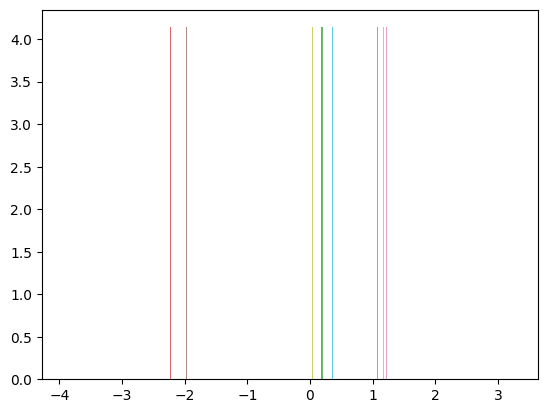

In [13]:
plt.hist(action_list, bins=30, density=True, alpha=0.7)
plt.show()